In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
diabetes = pd.read_csv('diabetes.csv')
print(diabetes.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### The diabetes dataset consists of 768 data points, with 9 features each

In [4]:
print("dimension of diabetes data: {}".format(diabetes.shape))

dimension of diabetes data: (768, 9)


### Outcome 0 means No diabetes, outcome 1 means diabetes
Of these 768 data points, 500 are labeled as 0 and 268 as 1:

In [5]:
print(diabetes.groupby('Outcome').size())

Outcome
0    500
1    268
dtype: int64


C:\Users\rajat.k.srivastava\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outcome', ylabel='count'>

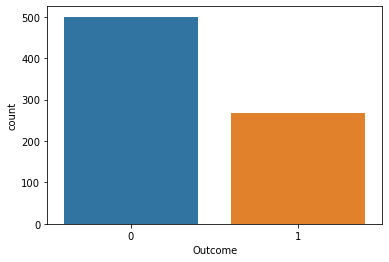

In [6]:
import seaborn as sns

sns.countplot(diabetes['Outcome'],label="Count")

In [54]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes.loc[:, diabetes.columns != 'Outcome'], diabetes['Outcome'], stratify=diabetes['Outcome'], random_state=66)

### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, y_test)))

Accuracy on training set: 0.917
Accuracy on test set: 0.792


In [46]:
gb.feature_importances_

array([0.05052062, 0.40538679, 0.03286922, 0.02963173, 0.04735818,
       0.23072019, 0.10210448, 0.10140879])

We are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

In [22]:
gb1 = GradientBoostingClassifier(random_state=0, max_depth=1)
gb1.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb1.score(X_test, y_test)))

Accuracy on training set: 0.804
Accuracy on test set: 0.781


In [47]:
gb1.feature_importances_

array([0.01983843, 0.57943018, 0.00607206, 0.00361876, 0.00624007,
       0.24868314, 0.05818316, 0.0779342 ])

In [23]:
gb2 = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gb2.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb2.score(X_test, y_test)))

Accuracy on training set: 0.802
Accuracy on test set: 0.776


In [48]:
gb2.feature_importances_

array([0.02585957, 0.60603751, 0.00206841, 0.00130338, 0.02356435,
       0.23505213, 0.03624517, 0.06986948])

Both methods of decreasing the model complexity reduced the training set accuracy, as expected. In this case, none of these methods increased the generalization performance of the test set.

Scaling the data made a huge difference! Now we are actually in an underfitting regime, where training and test set performance are quite similar but less close to 100% accuracy. From here, we can try increasing either C or gamma to fit a more complex model.

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [36]:
from sklearn.ensemble import AdaBoostClassifier
abc =  AdaBoostClassifier(random_state=0,learning_rate= 0.05)
abc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(abc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(abc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.773
Accuracy on test set: 0.755


In [49]:
abc.feature_importances_

array([0.  , 0.54, 0.  , 0.  , 0.  , 0.34, 0.  , 0.12])

In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
xgb_model = xgb.XGBClassifier(random_state=42)

xgb_model.fit(X_train_scaled, y_train)

# make predictions for test data
y_pred = xgb_model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 76.04%
